In [125]:
from UTILS import nll, train_test_split_ts
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, LayerNormalization, BatchNormalization, SimpleRNN
from tensorflow.keras.optimizers import Adam
import numpy as np, yfinance as yf, matplotlib.pyplot as plt, pandas as pd
from tqdm.auto import tqdm
import matplotlib as mpl
import math 
from arch import arch_model
import seaborn as sns, tensorflow.math as m
from sklearn.metrics import mean_squared_error as mse
pi = tf.constant(math.pi)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams['font.size'] = 15

In [37]:
def prepare_data(rets, log_vola = False, add_rv = True): #without rv 
    rets -= rets.mean()
    tf_rets = tf.convert_to_tensor(rets.values.reshape(-1,1), dtype = 'float32')
    garch = arch_model(tf_rets, mean='Constant', vol='GARCH', p=1, q=1)
    fit = garch.fit(disp = False)
    garch_vola = tf.convert_to_tensor(fit.conditional_volatility.reshape(-1,1), dtype = 'float32')
    if log_vola:
        garch_vola = tf.math.log(garch_vola)
    X = tf.concat((tf_rets, garch_vola), 1)
    if add_rv:
        rv = tf.convert_to_tensor(
            rets.rolling(22).std().dropna().values.reshape(-1,1),
            dtype = 'float32'
        )
        X = tf.concat((X[21:], tf.math.log(rv)), 1)
        data = tf.concat((tf_rets[22:], X[:-1]), 1)
    else:
        data = tf.concat((tf_rets[1:], X[:-1]), 1)
    return tf.reshape(data[:,0], (data[:,0].shape[0],1)), data[:,1:]

In [36]:
def prepare_data_(rets, p=1, q=1, log_vola = True):
    rets -= rets.mean()
    rets = rets.values
    garch = arch_model(rets, mean = 'Constant', vol = 'GARCH', p=1, q=1)
    fit = garch.fit(disp = False)
    garch_vola = fit.conditional_volatility
    if log_vola:
        garch_vola = np.log(garch_vola)
    rets_cols = []
    for i in range(p):
        rets_cols.append(rets[i:rets.shape[0]-p+i])
    prev_rets = np.array(rets_cols).transpose()
    vola_cols = []
    for j in range(q):
        vola_cols.append(garch_vola[j:garch_vola.shape[0]-q+j])
    prev_vola = np.array(vola_cols).transpose()
    data = np.concatenate((rets[p:rets.shape[0]].reshape(-1,1), prev_rets, prev_vola), 1)
    data = tf.convert_to_tensor(data, dtype = 'float32')
    return tf.reshape(data[:,0], (data[:,0].shape[0],1)), data[:,1:]

In [250]:
class NN(keras.Model):
    
    def __init__(
        self,
        hidden_size = [100],
        hidden_act = 'relu',
        last_act = 'sigmoid',
        norm_layer = True,
        reccurent_layer = 100
        
    ):
        super(NN, self).__init__()
        self.layers__ = []
        self.reccurent_layer = reccurent_layer
        if self.reccurent_layer>0:
            self.layers__.append(SimpleRNN(units = self.reccurent_layer, recurrent_dropout = .5))            
        for i in range(len(hidden_size)):
            self.layers__.append(Dense(units = hidden_size[i],
                                       activation = hidden_act,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1, l2=1)                                   
                                      ))
            if norm_layer:
                self.layers__.append(BatchNormalization())
        self.layers__.append(Dense(units = 1, activation = last_act))
        
    def call(
        self,
        x
    ):
        if self.reccurent_layer>0:
            x = tf.expand_dims(x, 1)
        for l in self.layers__:
            x = l(x)
        return x
    
    def train(
        self,
        x,
        y,
        lr = .01,
        epochs = 100,
        loss_fn = nll,
        optimizer = keras.optimizers.Adam
    ):
        self.optimizer =  optimizer(learning_rate=lr)
        print(30*'-'+'\nFITING THE NEURAL NET\n'+30*'-')
        self.loss_to_plot = []
        self.compile(optimizer = self.optimizer, loss = loss_fn)
        for epoch in tqdm(range(epochs)):
            with tf.GradientTape() as tape:
                logits = self(x)
                loss = loss_fn((logits)**2, y)
            if (epoch+1)%20==0:
                print(30*'-')
                print('EPOCH:{}'.format(epoch+1))
                print('NLL:{}'.format(loss))
            gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
            self.loss_to_plot.append(loss.numpy())
            
    def plot_loss(
        self
    ):
        plt.plot(self.loss_to_plot)
        
    def extended_evaluation(
        self,
        x,
        y
    ):
        garch = arch_model(y, mean='Constant', vol='GARCH', p=1, q=1)
        fit = garch.fit(disp = False)    
        garch_vola = fit.conditional_volatility
        tf_garch_vola = tf.expand_dims(tf.convert_to_tensor(garch_vola, dtype = 'float32'), 1)
        
        sns.histplot(np.abs((model(x)).numpy().ravel()), label = 'model', kde = True, color = 'orange')
        sns.histplot((garch_vola).ravel(), label = 'garch', kde = True)
        plt.legend()
        plt.show()

        rv = pd.DataFrame(y.numpy()).rolling(22).std().values
        tf_rv = tf.convert_to_tensor(rv, dtype = 'float32')

#         garch_nll = nll(tf_garch_vola**2, y)
#         rnn_nll = nll(model(x)**2, y)
        
        garch_nll = nll(tf_garch_vola[21:,0]**2, y[21:,0])
        rnn_nll = nll(model(x)[21:,0]**2, y[21:,0])
        rv_nll = nll(tf_rv[21:,0]**2, y[21:,0])
        

        garch_rmse = mse(rv[21:], tf_garch_vola[21:,0])**.5
        rnn_rmse = mse(rv[21:], abs(model(x)[21:,0]))**.5

        plt.plot(np.abs((model(x)).numpy().ravel()), label = 'nn', color = 'darkorange')
        plt.plot(tf_garch_vola, label = 'garch', color = 'blue')
        plt.plot(rv, color = 'green', linewidth = 3, label = 'RV')
        plt.legend()
        plt.text(x = 50,
                 y = 1.95*np.max(rv[~np.isnan(rv)]),
                 s = 'GARCH NLL    :{:5.0f}\nGARCH RMSE :{:1.4f}'.format(garch_nll, garch_rmse),
                 color = 'blue'
                )
        plt.text(x = 50,
                 y = 1.45*np.max(rv[~np.isnan(rv)]),
                 s = 'RNN NLL        :{:5.0f}\nRNN RMSE     :{:1.4f}'.format(rnn_nll, rnn_rmse),
                 color = 'darkorange'
                )
        plt.title('Comparison')
        print('NLL of realized volatility:{:5.0f}'.format(rv_nll))

        plt.show()

In [251]:
stock = yf.Ticker('^GSPC').history(start = '2015-01-01').Close
rets = 100*(stock.pct_change().dropna())
scale = 1 #already times 100
rets = rets/scale
rets_train, rets_test = train_test_split_ts(rets, .7)

In [252]:
# y_train, X_train = prepare_data(rets_train, log_vola = True, add_rv = False)
# y_test, X_test = prepare_data(rets_test, log_vola = True, add_rv = False)
y_train, X_train = prepare_data_(rets_train, log_vola = True, p=5, q =5)
y_test, X_test = prepare_data_(rets_test, log_vola = True, p=5, q =5)

In [364]:
model = NN(
    hidden_size = [],
    hidden_act = 'relu',
    last_act = 'exponential',
    norm_layer = True,
    reccurent_layer = 20
)

In [365]:
model.train(X_train, y_train, epochs = 100, optimizer = keras.optimizers.Adam)

------------------------------
FITING THE NEURAL NET
------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

------------------------------
EPOCH:20
NLL:1433.481689453125
------------------------------
EPOCH:40
NLL:1372.13525390625
------------------------------
EPOCH:60
NLL:1350.46240234375
------------------------------
EPOCH:80
NLL:1343.2158203125
------------------------------
EPOCH:100
NLL:1338.3546142578125


In [366]:
model.summary()

Model: "nn_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   multiple                  620       
                                                                 
 dense_71 (Dense)            multiple                  21        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


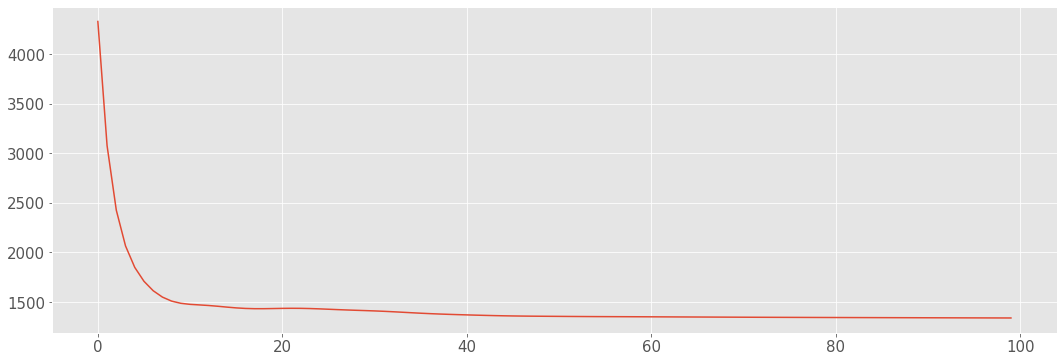

In [367]:
model.plot_loss()

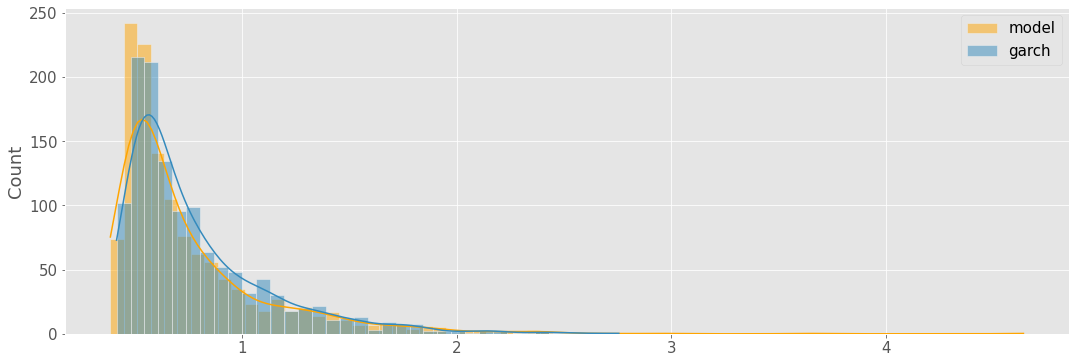

NLL of realized volatility: 1305


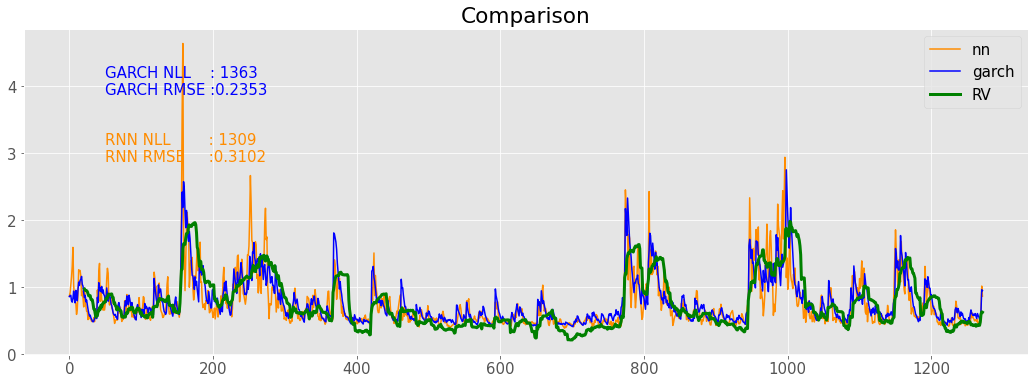

In [368]:
model.extended_evaluation(X_train, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=1373.7678>

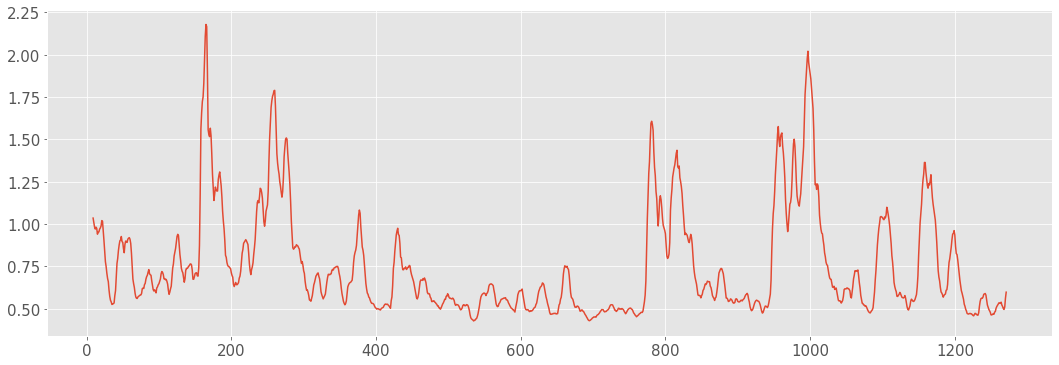

In [369]:
days = 10
smoothed = pd.DataFrame(model(X_train)[:,0]).rolling(days).mean()
tf_smoothed = tf.convert_to_tensor((smoothed[21+days:]).values.ravel(), dtype = 'float32')
plt.plot(smoothed)
nll(tf_smoothed**2,
    y_train[21+days:,0])

<BarContainer object of 1241 artists>

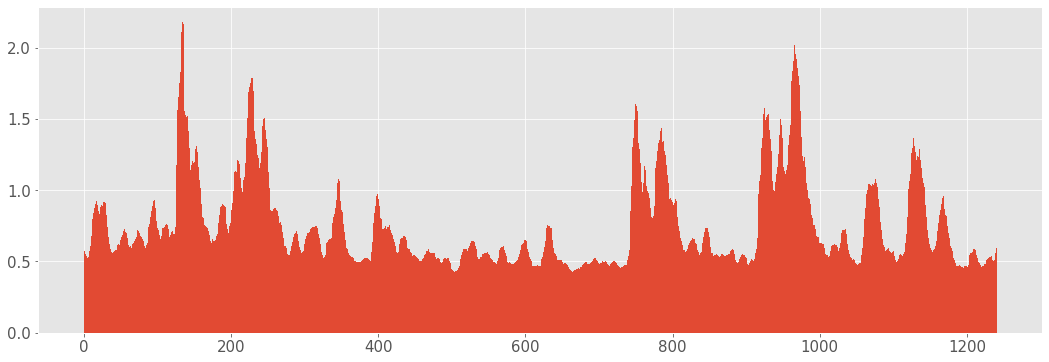

In [370]:
plt.bar(np.arange(tf_smoothed.shape[0]), tf_smoothed, width = 1)

<BarContainer object of 1272 artists>

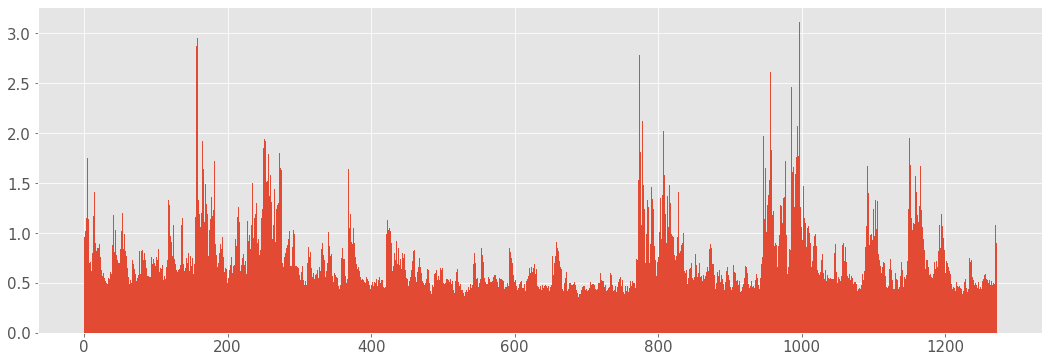

In [363]:
plt.bar(np.arange(model(X_train).shape[0]), model(X_train).numpy().ravel(), width = 1)